In [29]:
# fasterrcnn_pretrained_test.ipynb
# Purpose: Use pretrained Faster R-CNN to detect players on SoccerNet dataset frames

import os
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.utils import draw_bounding_boxes
from PIL import Image
from tqdm import tqdm
from collections import defaultdict

# --- CONFIG ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DATA_DIR = "../soccernet_data/tracking/test"
GT_FILENAME = "gt.txt"
IMAGE_FOLDER = "img1"
IMAGE_EXTS = ['.jpg', '.png']
NUM_OUTPUT_SAMPLE_IMAGES = 10
SCORE_THRESH = 0.8
IOU_THRESH = 0.5

# --- LOAD MODEL ---
print("Loading Faster R-CNN model...")

model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
model.to(DEVICE)


Loading Faster R-CNN model...


/home/bada/anaconda3/envs/practice/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bada/anaconda3/envs/practice/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [30]:

# --- IMAGE PREPROCESSING ---
transform = T.Compose([
    T.ToTensor(),
])

def load_gt_boxes(gt_path):
    gt_dict = defaultdict(list)
    if not os.path.exists(gt_path):
        return gt_dict
    with open(gt_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            frame, _, x, y, w, h, cls, _, _ = map(int, parts[:9])
            box = torch.tensor([x, y, x + w, y + h], device=DEVICE)
            gt_dict[frame].append(box)
    return gt_dict

# --- IOU CALCULATION ---
def compute_iou(box1, box2):
    if box1.size(0) == 0 or box2.size(0) == 0:
        return torch.zeros((box1.size(0), box2.size(0)), device=box1.device)
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    lt = torch.max(box1[:, None, :2], box2[:, :2])
    rb = torch.min(box1[:, None, 2:], box2[:, 2:])
    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]
    union = area1[:, None] + area2 - inter
    iou = inter / union
    return iou

# --- DRAW DETECTIONS + GT ---
def plot_gt_and_detections(image_tensor, detections, gt_boxes, score_thresh=0.8):
    boxes = detections['boxes']
    scores = detections['scores']
    keep = scores > score_thresh
    pred_boxes = boxes[keep]

    all_boxes = []
    labels = []
    colors = []

    for box in pred_boxes:
        all_boxes.append(box)
        labels.append("pred")
        colors.append("red")

    for box in gt_boxes:
        all_boxes.append(box)
        labels.append("gt")
        colors.append("green")

    if len(all_boxes) == 0:
        return T.ToPILImage()(image_tensor)

    all_boxes_tensor = torch.stack(all_boxes).to("cpu")
    drawn = draw_bounding_boxes(
        (image_tensor * 255).byte().cpu(),
        boxes=all_boxes_tensor,
        labels=labels,
        colors=colors,
        width=2
    )
    return T.ToPILImage()(drawn)

In [50]:
import random

sequence_usage_frame_count = 30

print("Using device:", DEVICE)
print("Number of images to sample:", NUM_OUTPUT_SAMPLE_IMAGES)
print("Score threshold:", SCORE_THRESH)
print("IOU threshold:", IOU_THRESH)

# --- EXECUTION ---
results = []
sample_frames = []

# Include both train and test sequences
seq_dirs = []
for split in ["train", "test"]:
    split_dir = os.path.join("../soccernet_data/tracking", split)
    if not os.path.exists(split_dir):
        continue
    for d in sorted(os.listdir(split_dir)):
        full_path = os.path.join(split_dir, d)
        if os.path.isdir(full_path):
            seq_dirs.append((split, d))



print("Processing sequences...")
# Get 30 random frames from each sequence
for split, seq_id in tqdm(seq_dirs, desc="Sequences", dynamic_ncols=True):
    seq_path = os.path.join("../soccernet_data/tracking", split, seq_id)
    img_dir = os.path.join(seq_path, IMAGE_FOLDER)
    gt_path = os.path.join(seq_path, "gt", GT_FILENAME)
    gt_dict = load_gt_boxes(gt_path)

    if not os.path.exists(img_dir):
        continue

    all_img_paths = sorted([
        os.path.join(img_dir, file)
        for file in os.listdir(img_dir)
        if any(file.lower().endswith(ext) for ext in IMAGE_EXTS)
    ])[:30]  # Randomized below

    random.shuffle(all_img_paths)  # Shuffle to get random frames
    all_img_paths = all_img_paths[:sequence_usage_frame_count]  # Sample random frames from each sequence

    for idx, path in enumerate(all_img_paths):
        try:
            img = Image.open(path).convert("RGB")
        except Exception as e:
            print(f"Skipping corrupted image: {path} | Error: {e}")
            continue

        img_tensor = transform(img).unsqueeze(0).to(DEVICE)
        filename = os.path.basename(path)

        try:
            frame_id = int(filename.split('.')[0])
        except ValueError:
            continue
        
        gt_boxes = gt_dict.get(frame_id, [])

        with torch.no_grad():
            output = model(img_tensor.to(DEVICE))[0]

        pred_boxes = output['boxes'][output['scores'] > SCORE_THRESH]


        # Accuracy
        if gt_boxes:
            gt_tensor = torch.stack(gt_boxes).to(DEVICE)
            if len(pred_boxes) > 0:
                ious = compute_iou(pred_boxes, gt_tensor)
                max_ious = ious.max(dim=1)[0]
                acc = (max_ious > IOU_THRESH).float().mean().item()
            else:
                acc = 0.0
        else:
            acc = 1.0 if len(pred_boxes) == 0 else 0.0

        results.append(acc)


        # Precision / Recall
        matched_gt = set()
        tp = fp = 0
        if len(pred_boxes) > 0 and len(gt_boxes) > 0:
            gt_tensor = torch.stack(gt_boxes).to(DEVICE)
            ious = compute_iou(pred_boxes, gt_tensor)
            for i in range(len(pred_boxes)):
                max_iou, gt_idx = ious[i].max(0)
                if max_iou > IOU_THRESH and gt_idx.item() not in matched_gt:
                    tp += 1
                    matched_gt.add(gt_idx.item())
                else:
                    fp += 1
        else:
            tp = 0
            fp = len(pred_boxes)

        fn = len(gt_boxes) - len(matched_gt)
        total_tp += tp
        total_fp += fp
        total_fn += fn

        # Sampled frames
        if len(sample_frames) < NUM_OUTPUT_SAMPLE_IMAGES and seq_id not in [s[0] for s in sample_frames]:
            img_vis = plot_gt_and_detections(img_tensor[0], output, gt_boxes)
            sample_frames.append((seq_id, filename, img_vis))

# --- DISPLAY SUMMARY ---
print(f"Number of sampled frames to output: {len(sample_frames)}")
print(f"Total frames processed: {len(results)}")

print("Final metrics:")
# Final metrics
precision = total_tp / (total_tp + total_fp + 1e-6)
recall = total_tp / (total_tp + total_fn + 1e-6)
avg_acc = sum(results) / len(results) if results else 0
print(f"\nAverage Detection Accuracy over {len(results)} frames: {avg_acc * 100:.2f}%")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f} frames: {avg_acc * 100:.2f}%")





Using device: cuda
Number of images to sample: 10
Score threshold: 0.8
IOU threshold: 0.5
Processing sequences...


Sequences: 100%|██████████| 106/106 [04:43<00:00,  2.67s/it]

Number of sampled frames to output: 10
Total frames processed: 3180
Final metrics:

Average Detection Accuracy over 3180 frames: 87.13%
Precision: 0.861, Recall: 0.820 frames: 87.13%


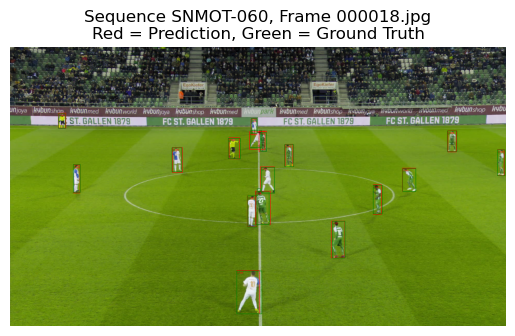

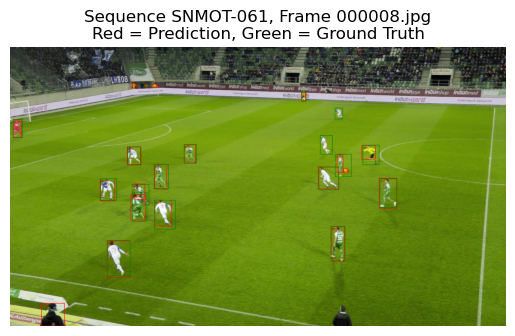

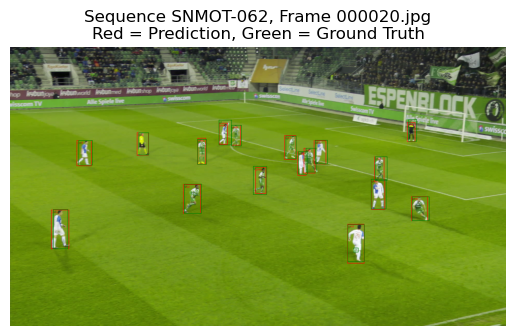

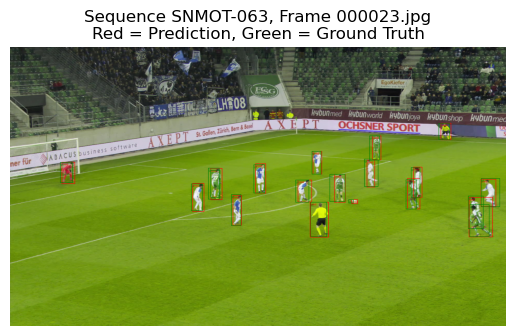

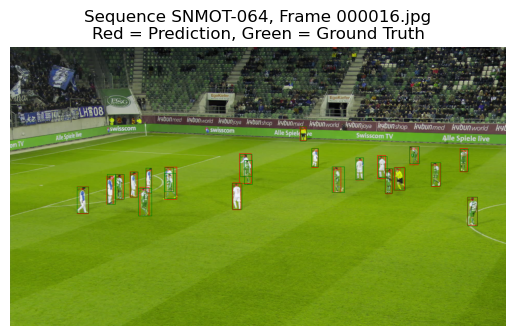

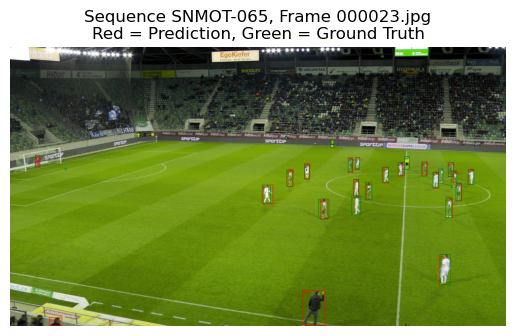

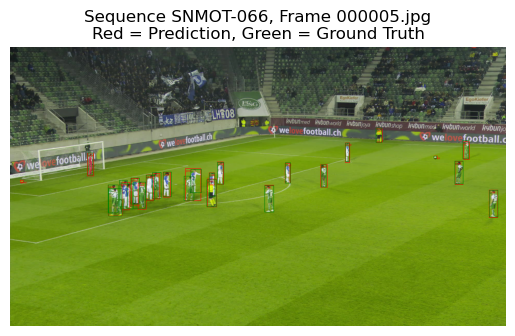

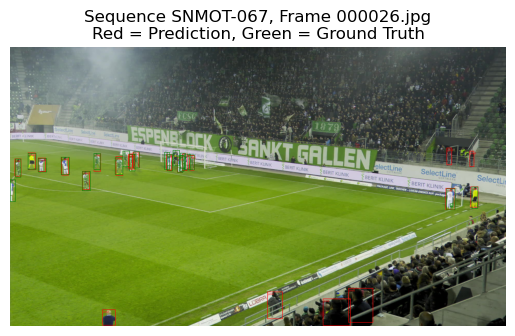

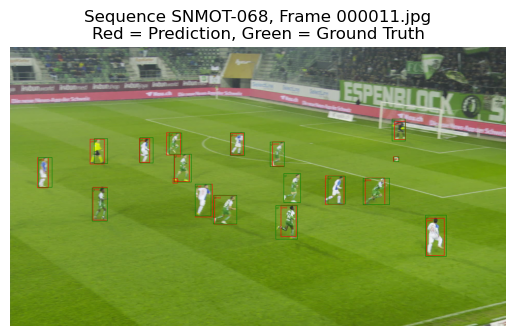

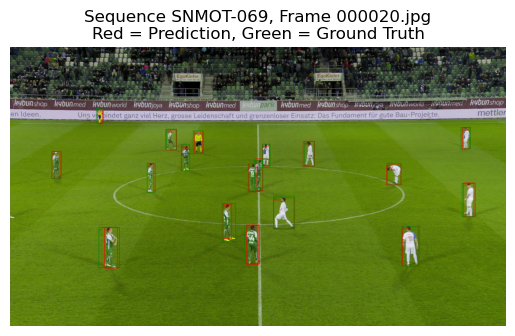

In [51]:


# --- SHOW EXAMPLES ---
for seq_id, filename, img in sample_frames:
    plt.imshow(img)
    plt.title(f"Sequence {seq_id}, Frame {filename}\nRed = Prediction, Green = Ground Truth")
    plt.axis("off")
    plt.show()
